# Initial Setup

### $0.1$ Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### $0.2$ Define File Paths

In [3]:
fi_t5_path = "D:/MG/！CUHKSZ/~！大二 下/FIN3080/Assignments/A2/A2_FI_T5(Merge Query).xlsx"
trd_mnth_path = "D:/MG/！CUHKSZ/~！大二 下/FIN3080/Assignments/A2/A2_TRD_Mnth.xlsx"

### $0.3$ Load & Clean Financial Data

In [4]:
# Load FI_T5 data, skipping the first two rows (units info) and setting stock code as string
fi_t5 = pd.read_excel(fi_t5_path, header=0, skiprows=[1, 2], dtype={'FI_T5.Stkcd': str})

# Filter for consolidated statements (Typrep == 'A') and select relevant columns
fi_t5 = fi_t5[fi_t5['FI_T5.Typrep'] == 'A']
fi_t5 = fi_t5[['FI_T5.Stkcd', 'FI_T5.Accper', 'FI_T9.F091001A']]

# Rename columns for simplicity
fi_t5 = fi_t5.rename(columns={
    'FI_T5.Stkcd': 'Stkcd',        # Stock code
    'FI_T5.Accper': 'Accper',      # Accounting period end date
    'FI_T9.F091001A': 'NPS'        # Net Assets per Share
})

# Convert Accper to datetime, dropping rows with invalid dates
fi_t5['Accper'] = pd.to_datetime(fi_t5['Accper'], errors='coerce')
fi_t5 = fi_t5.dropna(subset=['Accper'])

# Sort by stock code and accounting period, then remove duplicates
fi_t5 = fi_t5.sort_values(by=['Stkcd', 'Accper'])
fi_t5 = fi_t5.drop_duplicates(subset=['Stkcd', 'Accper'])

In [5]:
# Display the first few rows to verify
fi_t5.head()

,Stkcd,Accper,NPS
83,000001,2009-09-30,6.146785
82,000001,2009-12-31,6.591545
81,000001,2010-03-31,7.119722
80,000001,2010-06-30,8.729121
79,000001,2010-09-30,9.223531


### $0.4$ Load & Clean Trading Data

In [8]:
# Load TRD_Mnth data, skipping the first two rows and setting stock code as string
trd_mnth = pd.read_excel(trd_mnth_path, header=0, skiprows=[1, 2], dtype={'Stkcd': str})

# Select relevant columns and rename for clarity
trd_mnth = trd_mnth[['Stkcd', 'Trdmnt', 'Mclsprc']]
trd_mnth = trd_mnth.rename(columns={'Mclsprc': 'close'})  # Monthly closing price

# Convert Trdmnt to datetime, adjusting to the last day of the month
trd_mnth['Trdmnt'] = pd.to_datetime(trd_mnth['Trdmnt'], format='%Y-%m') + pd.offsets.MonthEnd(0)

In [9]:
# Display the first few rows to verify
trd_mnth.head()

,Stkcd,Trdmnt,close
0,000001,2009-12-31,24.37
1,000001,2010-01-31,21.70
2,000001,2010-02-28,22.45
3,000001,2010-03-31,23.20
4,000001,2010-04-30,20.56


### $0.5$ Match Monthly and Quarterly Data

- **Function**: `get_latest_quarter_date` iterates through each stock’s trading months and finds the most recent quarterly `Accper` before or on that month.
  - If no prior quarter exists, it assigns `NaT`.


In [10]:
# Define a function to find the latest quarterly date for each trading month
def get_latest_quarter_date(group):
    """
    For each trading month in a stock's group, find the most recent quarterly accounting date.
    Args:
        group: A DataFrame group of monthly data for a single stock.
    Returns:
        The group with an added 'latest_quarter' column.
    """
    stock_quarter = fi_t5[fi_t5['Stkcd'] == group.name]
    group['latest_quarter'] = [
        stock_quarter[stock_quarter['Accper'] <= t].sort_values('Accper').tail(1)['Accper'].iloc[0]
        if not stock_quarter[stock_quarter['Accper'] <= t].empty else pd.NaT
        for t in group['Trdmnt']
    ]
    return group

- **Grouping**: Uses `groupby('Stkcd')` to process each stock separately, adding a `'latest_quarter'` column.


In [11]:
# Apply the function to each stock group to match quarterly data
month_merged = trd_mnth.groupby('Stkcd').apply(get_latest_quarter_date)
month_merged = month_merged.reset_index(drop=True)

C:\Users\19927\AppData\Local\Temp\ipykernel_47304\1320742199.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  month_merged = trd_mnth.groupby('Stkcd').apply(get_latest_quarter_date)


- **Merging**: Combines monthly data (`month_merged`) with quarterly data (`fi_t5`) using a left join, ensuring all months are retained even if no quarterly match exists.

In [12]:
# Merge monthly and quarterly data
df = pd.merge(
    month_merged,
    fi_t5,
    how='left',                          # Left join to keep all monthly records
    left_on=['Stkcd', 'latest_quarter'], # Match on stock code and latest quarter date
    right_on=['Stkcd', 'Accper']         # Corresponding columns in quarterly data
)

In [13]:
# Display the first few rows to check the merge
df.head()

,Stkcd,Trdmnt,close,latest_quarter,Accper,NPS
0,000001,2009-12-31,24.37,2009-12-31,2009-12-31,6.591545
1,000001,2010-01-31,21.70,2009-12-31,2009-12-31,6.591545
2,000001,2010-02-28,22.45,2009-12-31,2009-12-31,6.591545
3,000001,2010-03-31,23.20,2010-03-31,2010-03-31,7.119722
4,000001,2010-04-30,20.56,2010-03-31,2010-03-31,7.119722


### $0.6$ Calculate Monthly P/B Ratio

In [14]:
# Calculate the monthly P/B ratio
df['monthly_PB'] = df['close'] / df['NPS']

# Replace infinite values (e.g., from division by zero) with NaN
df['monthly_PB'] = df['monthly_PB'].replace([np.inf, -np.inf], np.nan)

# Display the first few rows with P/B ratios
df[['Stkcd', 'Trdmnt', 'close', 'NPS', 'monthly_PB']].head()

,Stkcd,Trdmnt,close,NPS,monthly_PB
0,000001,2009-12-31,24.37,6.591545,3.697161
1,000001,2010-01-31,21.70,6.591545,3.292096
2,000001,2010-02-28,22.45,6.591545,3.405878
3,000001,2010-03-31,23.20,7.119722,3.258554
4,000001,2010-04-30,20.56,7.119722,2.887753


### $0.7$ Filter Out Extreme P/B Values

- **Function**: `filter_extreme_values` computes the 5th and 95th percentiles of P/B ratios within each month and keeps only values within this range, excluding `NaN`.  

In [15]:
# Define a function to filter out extreme P/B values (below 5th or above 95th percentile)
def filter_extreme_values(group):
    """
    Filter P/B ratios within a month to exclude values below 5% or above 95% percentiles.
    Args:
        group: A DataFrame group of data for a single month.
    Returns:
        Filtered group with P/B ratios in the desired range.
    """
    pb_5 = group['monthly_PB'].quantile(0.05, interpolation='linear')  # 5th percentile
    pb_95 = group['monthly_PB'].quantile(0.95, interpolation='linear') # 95th percentile
    return group[(group['monthly_PB'].notna()) & 
                 (group['monthly_PB'] >= pb_5) & 
                 (group['monthly_PB'] <= pb_95)]

- **Grouping**: Groups data by `Trdmnt` (trading month) and applies the filter.  

In [16]:
# Apply the filter by month
final_df = df.groupby('Trdmnt').apply(filter_extreme_values).reset_index(drop=True)

C:\Users\19927\AppData\Local\Temp\ipykernel_47304\136183634.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = df.groupby('Trdmnt').apply(filter_extreme_values).reset_index(drop=True)


In [17]:
# Display the filtered result
final_df[['Stkcd', 'Trdmnt', 'close', 'NPS', 'monthly_PB']].head()

,Stkcd,Trdmnt,close,NPS,monthly_PB
0,000001,2009-12-31,24.37,6.591545,3.697161
1,000002,2009-12-31,10.81,4.129845,2.617532
2,000005,2009-12-31,6.02,0.768185,7.836654
3,000006,2009-12-31,11.33,4.321826,2.621577
4,000009,2009-12-31,10.98,2.736748,4.012061


# 1. $P/B_i = \alpha + \beta_1 ROE_i + \beta_2 Stock Volatility_i + \epsilon_i.$

### $1.1$ Import Necessary Libraries

In [19]:
import statsmodels.api as sm

### $1.2$ Define File Paths

In [20]:
volatility_path = "D:/MG/！CUHKSZ/~！大二 下/FIN3080/Assignments/A2/A2_STK_MKT_STKBTAL.xlsx"

### $1.3$ Filter for December 2010

In [21]:
pb_2010dec = final_df[final_df['Trdmnt'] == '2010-12-31'][['Stkcd', 'monthly_PB']]

### $1.4$ Load and Prepare ROE Data

In [22]:
# Load FI_T5 data again to get ROE for 2010Q4
fi_t5_full = pd.read_excel(fi_t5_path, header=0, skiprows=[1, 2], dtype={'FI_T5.Stkcd': str})
roe_2010q4 = fi_t5_full[(fi_t5_full['FI_T5.Typrep'] == 'A') & (fi_t5_full['FI_T5.Accper'] == '2010-12-31')]
roe_2010q4 = roe_2010q4[['FI_T5.Stkcd', 'FI_T5.F050504C']]
roe_2010q4 = roe_2010q4.rename(columns={'FI_T5.Stkcd': 'Stkcd', 'FI_T5.F050504C': 'ROE'})

### $1.5$ Load and Prepare Volatility Data

In [23]:
# Load volatility data for 2010-12-31
volatility_df = pd.read_excel(volatility_path, header=0, skiprows=[1, 2], dtype={'Symbol': str})
volatility_df = volatility_df[volatility_df['TradingDate'] == '2010-12-31']
volatility_df = volatility_df[['Symbol', 'Volatility']]
volatility_df = volatility_df.rename(columns={'Symbol': 'Stkcd'})

### $1.6$ Merge Data

In [24]:
# Merge P/B, ROE, and Volatility data
merged_df = pd.merge(pb_2010dec, roe_2010q4, on='Stkcd', how='inner')
merged_df = pd.merge(merged_df, volatility_df, on='Stkcd', how='inner')

# Drop rows with missing values
merged_df = merged_df.dropna()

In [25]:
# Display the first few rows
print(merged_df.head())

    Stkcd  monthly_PB       ROE  Volatility
0  000001    1.657604  0.234177    0.375077
1  000002    1.655741  0.176802    0.360978
2  000004    7.824706  0.184460    0.382118
3  000005    4.968947 -0.006426    0.409691
4  000006    2.072690  0.209026    0.502408


### $1.7$ Perform Regression

- Defines the dependent variable (Y) as `monthly_PB` and independent variables (X) as `ROE` and `Volatility`.
- Adds a constant term for the intercept (α).
- Fits an OLS regression model and prints a detailed summary, including coefficients, p-values, R-squared, etc.

In [27]:
# Prepare regression variables
X = merged_df[['ROE', 'Volatility']]
X = sm.add_constant(X)  # Adds intercept term
Y = merged_df['monthly_PB']

# Fit the OLS regression model
model = sm.OLS(Y, X).fit()

In [28]:
# Print regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             monthly_PB   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     62.61
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           9.13e-27
Time:                        17:12:27   Log-Likelihood:                -3101.9
No. Observations:                1396   AIC:                             6210.
Df Residuals:                    1393   BIC:                             6226.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8002      0.348      2.298      0.0

### $1.8$ Check Correlation (Optional Diagnostics)

In [29]:
# Check correlation between independent variables
print("Correlation between ROE and Volatility:")
print(merged_df[['ROE', 'Volatility']].corr())

Correlation between ROE and Volatility:
                 ROE  Volatility
ROE         1.000000    0.005198
Volatility  0.005198    1.000000


### $1.9$ Visualize Relationships (Optional)

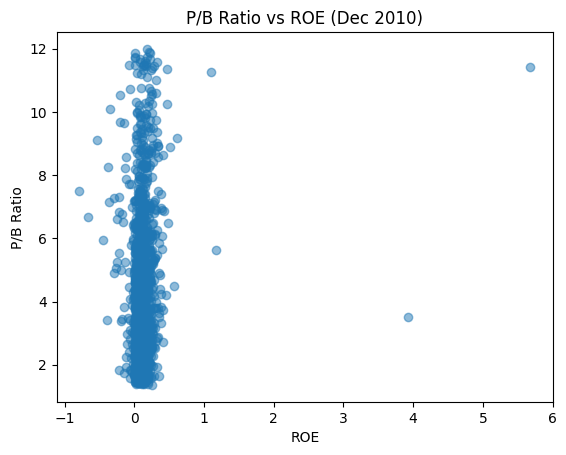

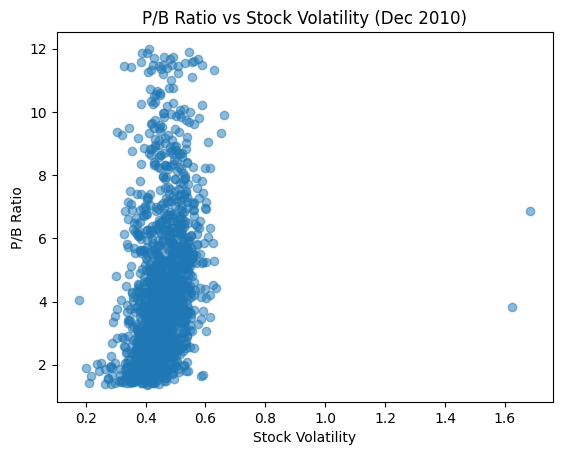

In [30]:
# Scatter plot of P/B vs ROE
plt.scatter(merged_df['ROE'], merged_df['monthly_PB'], alpha=0.5)
plt.xlabel('ROE')
plt.ylabel('P/B Ratio')
plt.title('P/B Ratio vs ROE (Dec 2010)')
plt.show()

# Scatter plot of P/B vs Volatility
plt.scatter(merged_df['Volatility'], merged_df['monthly_PB'], alpha=0.5)
plt.xlabel('Stock Volatility')
plt.ylabel('P/B Ratio')
plt.title('P/B Ratio vs Stock Volatility (Dec 2010)')
plt.show()

## Regression Results

Based on the OLS regression output provided, the estimated model is:

$$P/B_i = 0.8002 + 1.1590 \cdot ROE_i + 7.8108 \cdot \text{Stock Volatility}_i + \epsilon_i$$

Here are the detailed regression results:

- **Dependent Variable**: Monthly P/B Ratio (`monthly_PB`)
- **Number of Observations**: 1,396
- **R-squared**: 0.082
- **Adjusted R-squared**: 0.081
- **F-statistic**: 62.61 (p-value: 9.13e-27)

### Coefficients and Statistical Significance:
1. **Intercept (α)**:
   - Coefficient: 0.8002
   - Standard Error: 0.348
   - t-statistic: 2.298
   - p-value: 0.022
   - 95% Confidence Interval: [0.117, 1.483]

2. **ROE (β₁)**:
   - Coefficient: 1.1590
   - Standard Error: 0.281
   - t-statistic: 4.130
   - p-value: 0.000
   - 95% Confidence Interval: [0.609, 1.709]

3. **Stock Volatility (β₂)**:
   - Coefficient: 7.8108
   - Standard Error: 0.753
   - t-statistic: 10.379
   - p-value: 0.000
   - 95% Confidence Interval: [6.334, 9.287]

### Model Diagnostics:
- **Log-Likelihood**: -3101.9
- **AIC**: 6210
- **BIC**: 6226
- **Omnibus**: 226.772 (p-value: 0.000)
- **Durbin-Watson**: 1.937
- **Jarque-Bera (JB)**: 372.281 (p-value: 1.45e-81)
- **Skew**: 1.062
- **Kurtosis**: 4.375
- **Condition Number**: 15.3

---

## Discussion of Findings

### 1. Intercept (α = 0.8002, p = 0.022)
- **Interpretation**: The intercept represents the expected P/B ratio when both ROE and Stock Volatility are zero. A value of 0.8002, which is statistically significant at the 5% level (p = 0.022), suggests that even in the absence of profitability (ROE = 0) and volatility (Volatility = 0), A-share firms in December 2010 had a P/B ratio below 1. This could indicate that, on average, the market valued these firms at a discount to their book value, possibly reflecting conservative valuations or lack of growth expectations in the absence of profitability and risk.
- **Economic Insight**: The positive and significant intercept implies a baseline valuation exists, but its value less than 1 might suggest undervaluation or a market environment cautious about firms with no profitability or risk exposure.

### 2. ROE Coefficient (β₁ = 1.1590, p < 0.001)
- **Interpretation**: The coefficient for ROE is positive and highly statistically significant (p < 0.001), indicating a positive relationship between Return on Equity and the P/B ratio. For a 1-unit increase in ROE (e.g., from 0 to 1, or 0% to 100%), the P/B ratio increases by approximately 1.159 units, holding volatility constant.
- **Economic Insight**: This aligns with financial theory: higher ROE reflects greater profitability and efficiency in utilizing equity, which investors reward with higher valuations relative to book value. The magnitude (1.159) suggests a moderate but meaningful premium for profitability, consistent with expectations that profitable firms command higher market valuations.

### 3. Stock Volatility Coefficient (β₂ = 7.8108, p < 0.001)
- **Interpretation**: The coefficient for Stock Volatility is positive, large, and highly significant (p < 0.001). A 1-unit increase in volatility (e.g., a standard deviation increase in log returns over the past 250 trading days) is associated with a 7.8108-unit increase in the P/B ratio, holding ROE constant.
- **Economic Insight**: This result is surprising and counterintuitive. Typically, higher volatility (risk) is expected to reduce valuations (i.e., a negative coefficient) as investors demand a risk premium or discount risky stocks. Here, the positive and substantial coefficient suggests that in December 2010, A-share firms with higher volatility were valued more highly. This could reflect:
  - **Market Sentiment**: In late 2010, the Chinese A-share market might have been in a speculative phase, where high-volatility stocks (possibly growth stocks or those with high trading activity) were favored by investors, driving up their P/B ratios.
  - **Data Context**: The volatility measure (log return standard deviation over 250 days) might capture momentum or investor attention rather than pure risk, leading to higher valuations.
  - **Potential Mis-specification**: The model might omit variables (e.g., growth expectations, market capitalization) that correlate with volatility and drive P/B ratios upward.

### 4. Model Fit (R-squared = 0.082, Adjusted R-squared = 0.081)
- **Interpretation**: The R-squared of 0.082 indicates that ROE and Stock Volatility together explain only 8.2% of the variation in P/B ratios across the 1,396 A-share firms in December 2010. The adjusted R-squared (0.081) is nearly identical, suggesting the model’s explanatory power is modest but stable with two predictors.
- **Economic Insight**: The low R-squared is not unusual in cross-sectional financial regressions, where many factors beyond ROE and volatility (e.g., industry effects, macroeconomic conditions, investor sentiment) influence valuations. The highly significant F-statistic (62.61, p = 9.13e-27) confirms that the model is statistically meaningful, despite its limited explanatory power.

### 5. Diagnostic Statistics
- **Normality of Residuals**: The Omnibus (226.772, p = 0.000) and Jarque-Bera (372.281, p = 1.45e-81) tests reject the null hypothesis of normally distributed residuals. The positive skew (1.062) and kurtosis (4.375) indicate a right-skewed distribution with heavier tails than a normal distribution. This suggests potential outliers or a non-linear relationship not captured by the linear model.
- **Autocorrelation**: The Durbin-Watson statistic (1.937) is close to 2, indicating no significant autocorrelation in the residuals, which is expected in a cross-sectional (not time-series) regression.
- **Multicollinearity**: The condition number (15.3) is below 30, suggesting no severe multicollinearity between ROE and Volatility, though a correlation check could confirm this.

### 6. Economic and Contextual Analysis
- **Positive Volatility Effect**: The most striking finding is the positive relationship between volatility and P/B, which contradicts the typical risk-return tradeoff. In December 2010, China’s A-share market might have been recovering from the 2008-2009 financial crisis, with investors chasing high-volatility stocks (e.g., small-cap or speculative firms) expecting higher returns. This could explain the large positive coefficient.
- **Moderate ROE Effect**: The positive ROE effect is intuitive and aligns with valuation principles, though its modest size (1.159) suggests profitability was not the dominant driver of valuations at that time.
- **Market Conditions**: The low R-squared and unexpected volatility result imply that other factors—possibly market momentum, policy changes, or sector-specific trends in late 2010—played a larger role in driving P/B ratios.

---

## Conclusion
The regression results show that in December 2010, A-share firms’ P/B ratios were positively influenced by both ROE (1.1590) and Stock Volatility (7.8108), with a baseline P/B of 0.8002 when both predictors are zero. While the ROE effect aligns with expectations, the strong positive volatility effect is unexpected and suggests a unique market dynamic—possibly speculative behavior or a preference for high-risk stocks—at that time. The model explains only 8.2% of P/B variation, indicating other unmodeled factors were significant drivers. These findings highlight the complexity of valuation in the A-share market and the need for further investigation into the role of volatility in late 2010.

# 2. Construct $10$ portfolios

### $2.1$ Import Necessary Libraries

In [32]:
from pandas.tseries.offsets import MonthEnd

### $2.2$ Load and Adjust Data

In [33]:
# Define file path
trd_mnth_path = "D:/MG/！CUHKSZ/~！大二 下/FIN3080/Assignments/A2/A2_TRD_Mnth.xlsx"

# Load data, skipping unit rows, setting stock code as string
trd_mnth = pd.read_excel(trd_mnth_path, header=0, skiprows=[1, 2], dtype={'Stkcd': str})

# Select relevant columns including returns
trd_mnth = trd_mnth[['Stkcd', 'Trdmnt', 'Mclsprc', 'Mretnd']]
trd_mnth = trd_mnth.rename(columns={'Mclsprc': 'close', 'Mretnd': 'return'})

# !IMPORTANT: Convert Trdmnt to datetime and set to month-end
# This ensures proper alignment with quarterly data and portfolio rebalancing
trd_mnth['Trdmnt'] = pd.to_datetime(trd_mnth['Trdmnt'], format='%Y-%m') + pd.offsets.MonthEnd(0)

### $2.3$ Merge with Quarterly Data

In [34]:
month_merged = trd_mnth.groupby('Stkcd').apply(get_latest_quarter_date).reset_index(drop=True)
df = pd.merge(
    month_merged,
    fi_t5,
    how='left',
    left_on=['Stkcd', 'latest_quarter'],
    right_on=['Stkcd', 'Accper']
)

C:\Users\19927\AppData\Local\Temp\ipykernel_47304\3944867711.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  month_merged = trd_mnth.groupby('Stkcd').apply(get_latest_quarter_date).reset_index(drop=True)


In [35]:
# !IMPORTANT: Calculate monthly P/B ratio
# This is the basis for sorting stocks into deciles
df['monthly_PB'] = df['close'] / df['NPS']
df['monthly_PB'] = df['monthly_PB'].replace([np.inf, -np.inf], np.nan)

In [36]:
# Filter extreme P/B values
final_df = df.groupby('Trdmnt').apply(filter_extreme_values).reset_index(drop=True)
final_df.head()

C:\Users\19927\AppData\Local\Temp\ipykernel_47304\565107220.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = df.groupby('Trdmnt').apply(filter_extreme_values).reset_index(drop=True)


,Stkcd,Trdmnt,close,return,latest_quarter,Accper,NPS,monthly_PB
0,000001,2009-12-31,24.37,0.004534,2009-12-31,2009-12-31,6.591545,3.697161
1,000002,2009-12-31,10.81,-0.062446,2009-12-31,2009-12-31,4.129845,2.617532
2,000005,2009-12-31,6.02,-0.044444,2009-12-31,2009-12-31,0.768185,7.836654
3,000006,2009-12-31,11.33,-0.116225,2009-12-31,2009-12-31,4.321826,2.621577
4,000009,2009-12-31,10.98,-0.129952,2009-12-31,2009-12-31,2.736748,4.012061


### $2.4$ Add Lagged P/B Ratios

Creates a column for the previous month's P/B ratio, which determines portfolio assignments.

In [37]:
# !IMPORTANT: Add previous month's trading date
# This enables lagging P/B ratios for portfolio formation
final_df['prev_Trdmnt'] = final_df['Trdmnt'] - MonthEnd(1)

# Create lagged P/B DataFrame
lagged_df = final_df[['Stkcd', 'Trdmnt', 'monthly_PB']].rename(columns={'monthly_PB': 'lagged_PB'})

# !IMPORTANT: Merge to get last-month P/B ratios
# This aligns each stock's current month with its prior month's P/B
final_df = pd.merge(
    final_df,
    lagged_df[['Stkcd', 'Trdmnt', 'lagged_PB']],
    how='left',
    left_on=['Stkcd', 'prev_Trdmnt'],
    right_on=['Stkcd', 'Trdmnt'],
    suffixes=('', '_lagged')
)

# Clean up redundant column
final_df = final_df.drop(columns=['Trdmnt_lagged'])

### $2.5$ Assign Deciles

Sorts stocks into 10 portfolios each month based on lagged P/B ratios.

In [38]:
# Define function to assign deciles
def assign_decile(group):
    try:
        # !IMPORTANT: Assign deciles based on lagged P/B
        # This creates the 10 portfolios for each month
        group['decile'] = pd.qcut(group['lagged_PB'], 10, labels=False, duplicates='drop')
    except ValueError:
        # Handle cases with too few unique values
        group['decile'] = np.nan
    return group


In [39]:
# Apply decile assignment
final_df = final_df.groupby('Trdmnt').apply(assign_decile).reset_index(drop=True)
final_df.head()

C:\Users\19927\AppData\Local\Temp\ipykernel_47304\2362395415.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = final_df.groupby('Trdmnt').apply(assign_decile).reset_index(drop=True)


,Stkcd,Trdmnt,close,return,latest_quarter,Accper,NPS,monthly_PB,prev_Trdmnt,lagged_PB,decile
0,000001,2009-12-31,24.37,0.004534,2009-12-31,2009-12-31,6.591545,3.697161,2009-11-30,NaN,NaN
1,000002,2009-12-31,10.81,-0.062446,2009-12-31,2009-12-31,4.129845,2.617532,2009-11-30,NaN,NaN
2,000005,2009-12-31,6.02,-0.044444,2009-12-31,2009-12-31,0.768185,7.836654,2009-11-30,NaN,NaN
3,000006,2009-12-31,11.33,-0.116225,2009-12-31,2009-12-31,4.321826,2.621577,2009-11-30,NaN,NaN
4,000009,2009-12-31,10.98,-0.129952,2009-12-31,2009-12-31,2.736748,4.012061,2009-11-30,NaN,NaN


### $2.6$ Calculate Portfolio Returns

Computes monthly returns for each decile portfolio and their averages over the period.

In [41]:
# Filter for Jan 2010 to Dec 2024
final_df = final_df[(final_df['Trdmnt'] >= '2010-01-31') & (final_df['Trdmnt'] <= '2024-12-31')]

# !IMPORTANT: Calculate equal-weighted portfolio returns
# This averages returns within each decile per month
portfolio_returns = final_df.groupby(['Trdmnt', 'decile'])['return'].mean().reset_index()

# !IMPORTANT: Compute average returns across all months
# This summarizes performance for the bar chart
average_returns = portfolio_returns.groupby('decile')['return'].mean().reset_index()

### $2.7$ Plot Results

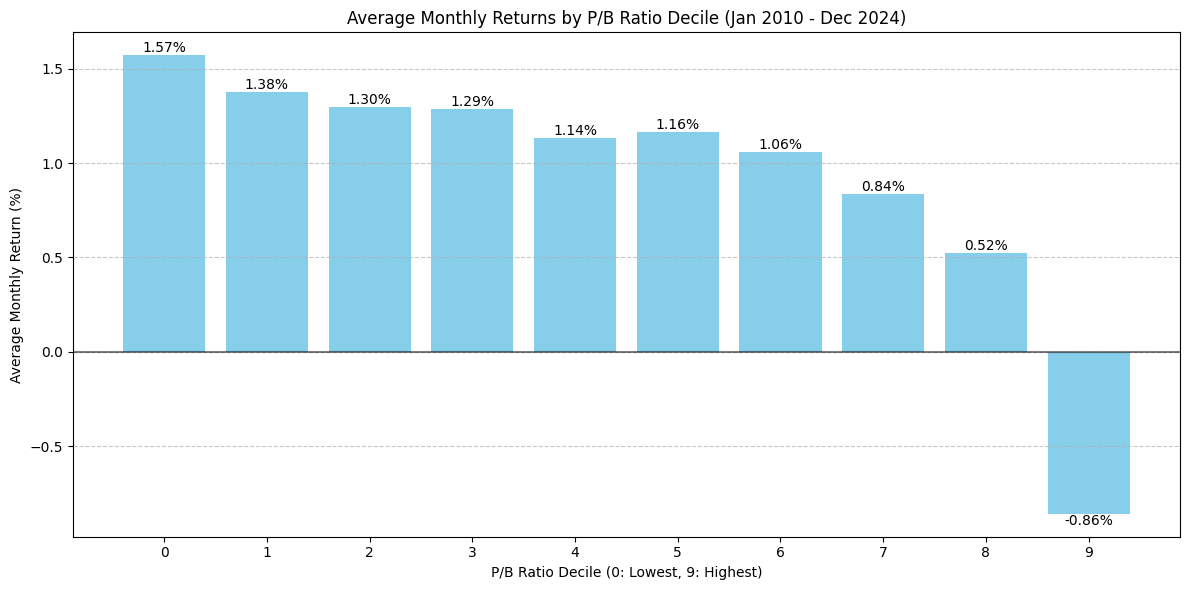

In [43]:
plt.figure(figsize=(12, 6))
bars = plt.bar(average_returns['decile'], average_returns['return'] * 100, color='skyblue')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom' if height >= 0 else 'top')  # Dynamic label position
plt.xlabel('P/B Ratio Decile (0: Lowest, 9: Highest)')
plt.ylabel('Average Monthly Return (%)')
plt.title('Average Monthly Returns by P/B Ratio Decile (Jan 2010 - Dec 2024)')
plt.xticks(range(10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

### $2.8$ Plot Cumulative Returns

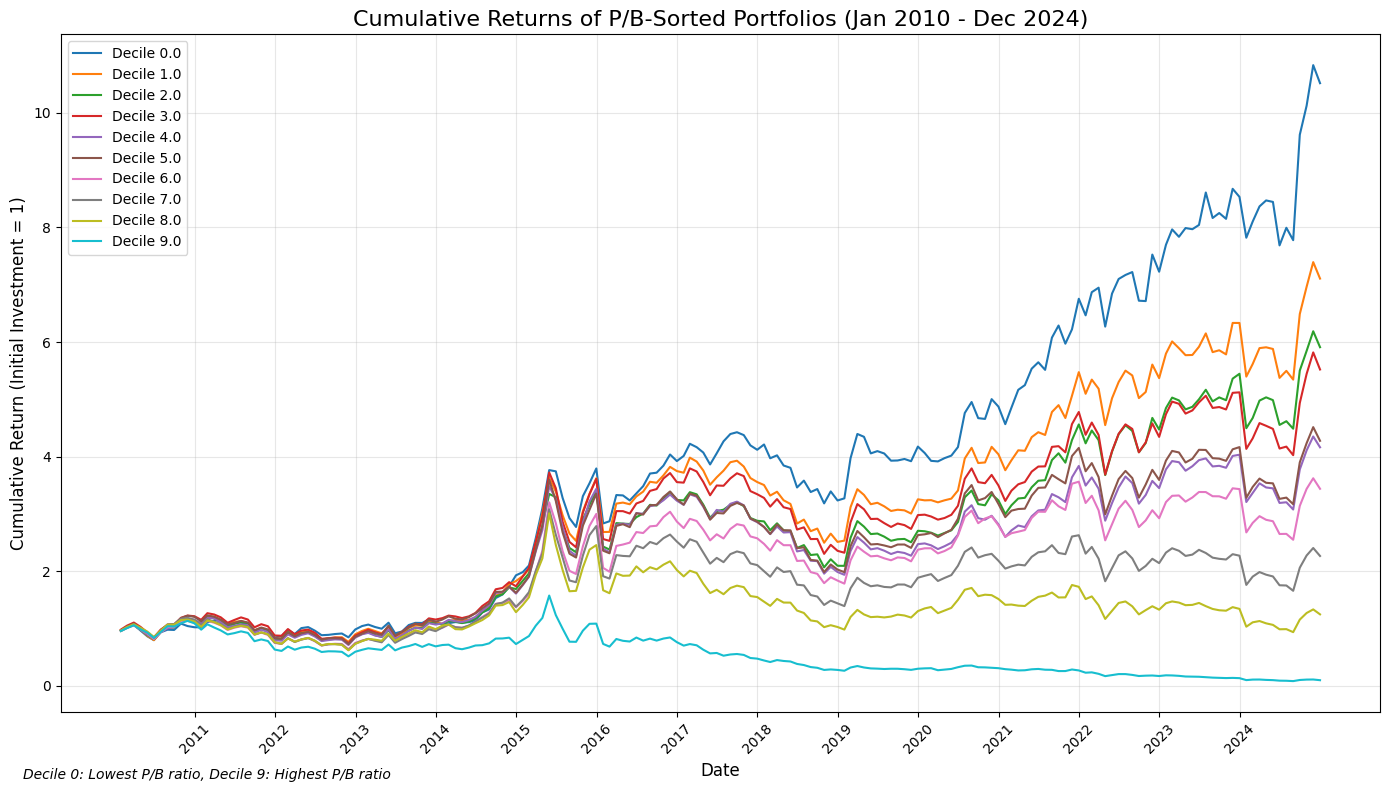

In [45]:
portfolio_returns_pivot = portfolio_returns.pivot(index='Trdmnt', columns='decile', values='return')
cumulative_returns = (1 + portfolio_returns_pivot).cumprod()

colors = plt.cm.tab10(np.linspace(0, 1, 10))
plt.figure(figsize=(14, 8))
for i, col in enumerate(cumulative_returns.columns):
    plt.plot(cumulative_returns.index, cumulative_returns[col], 
             label=f'Decile {col}', color=colors[i], linewidth=1.5)

plt.title('Cumulative Returns of P/B-Sorted Portfolios (Jan 2010 - Dec 2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Initial Investment = 1)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
years = pd.date_range(start='2010-01-31', end='2024-12-31', freq='YS')
plt.xticks(years, [d.strftime('%Y') for d in years], rotation=45)
plt.figtext(0.02, 0.02, 'Decile 0: Lowest P/B ratio, Decile 9: Highest P/B ratio', 
            fontsize=10, style='italic')
plt.tight_layout()
plt.show()

### $2.9$ Display Final Metrics

In [46]:
final_returns = cumulative_returns.iloc[-1]
print("Final Cumulative Returns (Initial Investment = 1):")
for decile in final_returns.index:
    print(f"Decile {decile}: {final_returns[decile]:.4f}")

years = len(cumulative_returns) / 12  # Assuming monthly data
annualized_returns = (final_returns ** (1/years) - 1) * 100
print("\nAnnualized Returns (%):")
for decile in annualized_returns.index:
    print(f"Decile {decile}: {annualized_returns[decile]:.2f}%")

# Display average returns
print("\nAverage Monthly Returns (%):")
average_returns['return'] = average_returns['return'] * 100
print(average_returns.round(4))

Final Cumulative Returns (Initial Investment = 1):
Decile 0.0: 10.5150
Decile 1.0: 7.1064
Decile 2.0: 5.9093
Decile 3.0: 5.5206
Decile 4.0: 4.1634
Decile 5.0: 4.2762
Decile 6.0: 3.4395
Decile 7.0: 2.2673
Decile 8.0: 1.2491
Decile 9.0: 0.1006

Annualized Returns (%):
Decile 0.0: 16.98%
Decile 1.0: 13.97%
Decile 2.0: 12.57%
Decile 3.0: 12.06%
Decile 4.0: 9.98%
Decile 5.0: 10.17%
Decile 6.0: 8.58%
Decile 7.0: 5.61%
Decile 8.0: 1.49%
Decile 9.0: -14.20%

Average Monthly Returns (%):
   decile  return
0     0.0  1.5723
1     1.0  1.3787
2     2.0  1.2977
3     3.0  1.2864
4     4.0  1.1358
5     5.0  1.1627
6     6.0  1.0589
7     7.0  0.8385
8     8.0  0.5218
9     9.0 -0.8592
